# HOTEL REVIEW - SENTIMENT ANALYSIS

Sentiment Analysis is the process of computationally identifying and categorizing opinions expressed in a piece of text, with the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information. For this project, we use sentiment analysis to find out customer review and rating (1 to 5 stars). 

Data source : [click here](https://www.kaggle.com/datasets/thedevastator/tripadvisor-hotel-reviews)

## IMPORT LIBRARY

In [1]:
!pip install wordcloud

In [2]:
!pip install nltk

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.colors as mcolors

from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from textwrap import wrap
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.metrics import classification_report


from nltk.sentiment.vader import SentimentIntensityAnalyzer

import string

import gensim
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import re

from PIL import Image

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


True

In [7]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...


True

## LOAD DATASET

In [9]:
df = pd.read_csv('TripAdvisor.csv', encoding = 'ISO-8859-1')

In [10]:
df.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   S.No.   20491 non-null  int64 
 1   Review  20491 non-null  object
 2   Rating  20491 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 480.4+ KB


## DATA PREPOCESSING

In [12]:
# Sample data

df = df.sample(frac = 0.1, replace = False, random_state=42)

Proceed the modeling and analysis with sample data to speed up computation

In [13]:
# drop unused column

df = df.drop(['S.No.'], axis = 1)

In [14]:
# Count null values

df.isna().sum()

Review    0
Rating    0
dtype: int64

In [15]:
# Check if there any duplicated values

df.duplicated().sum()

0

We need to clean up the review column. 

First we create a function to help identify type of the words (adjective, verb, noun, adverb). Then we create a function to :

- remove '\', 'empty' review and words with only 1 letter
- lower all text
- Tokenize and split text to words
- Remove numbers and stop words ( 'a', 'an', 'the', 'of', 'in', etc.), to help improve accuracy to give more focus to the important information
- Part-of-Speech (POS) tagging: Categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context indicates how the word functions in meaning as well as grammatically within the sentence
- lemmatize the text: transform every word into their root form (caring -> care)

In [16]:
# upload stopwords txt

gist_file = open("gist_stopwords.txt", "r")
content = gist_file.read()
stopwords = content.split(",")
gist_file.close()

In [17]:
# return the wordnet object value

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # remove \
    text = text.replace('\t', '')
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    text = [x for x in text if x not in stopwords]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = ' '.join(text)
    return(text)


In [18]:
# Apply clean_text function

df['Clean_Review'] = df['Review'].apply(lambda x: clean_text(x))

In [19]:
df.head()

,Review,Rating,Clean_Review
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...


In [20]:
# add sentiment analysis

sid = SentimentIntensityAnalyzer()

df['Sentiments'] = df['Review'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)

In [21]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801


In [22]:
# add total number of characters column

df['Chars'] = df['Review'].apply(lambda x: len(x))

# add total number of words column

df['Words'] = df['Review'].apply(lambda x: len(x.split(' ')))

In [23]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98


In [24]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['Clean_Review'].apply(lambda x: x.split(' ')))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = df['Clean_Review'].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ['doc2vec_vector_' + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

Using **Doc2Vec** to transform each text into numerical vectors.

In [25]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48,0.007883,0.354603,0.129171,-0.066103,-0.027625
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360,1.911419,2.128553,0.745342,-2.029231,0.531722
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27,-0.125178,0.361736,-0.137931,-0.170933,-0.159253
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320,0.200774,1.022699,1.663106,-2.619904,-0.159047
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98,0.389365,0.631180,0.595815,-0.875913,-0.134321


In [28]:
# add tf-idfs

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df['Clean_Review']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

Add the **TF-IDF** (Term Frequency - Inverse Document Frequency) values for every words to find out which word that has useful information for analysis.

The TF-IDF metric solves this problem:
- TF computes the classic number of times the word appears in the text
- IDF computes the relative importance of this word which depends on how many texts the word can be found

In [29]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words,doc2vec_vector_0,...,word_yard,word_year,word_yell,word_yellow,word_yes,word_yogurt,word_york,word_you,word_young,word_yummy
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48,0.007883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360,1.911419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27,-0.125178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320,0.200774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053745,0.0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98,0.389365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [30]:
# create the positive and negative label

df['posneg'] = df['Rating'].apply(lambda x: 0 if x < 5 else 1)

df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words,doc2vec_vector_0,...,word_year,word_yell,word_yellow,word_yes,word_yogurt,word_york,word_you,word_young,word_yummy,posneg
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48,0.007883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360,1.911419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27,-0.125178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320,0.200774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053745,0.0,0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98,0.389365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


## EXPLORATORY DATA ANALYSIS

In [31]:
# Calculate Positive and Negative Review

train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Clean_Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Clean_Review']

In [32]:
# Generate WordCloud Function

def wordCloud_generator(data, color, color_map):
    
    wave_mask = np.array(Image.open('cloud.png'))
    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                          mask = wave_mask
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

In [33]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

FileNotFoundError: [Errno 2] No such file or directory: 'cloud.png'

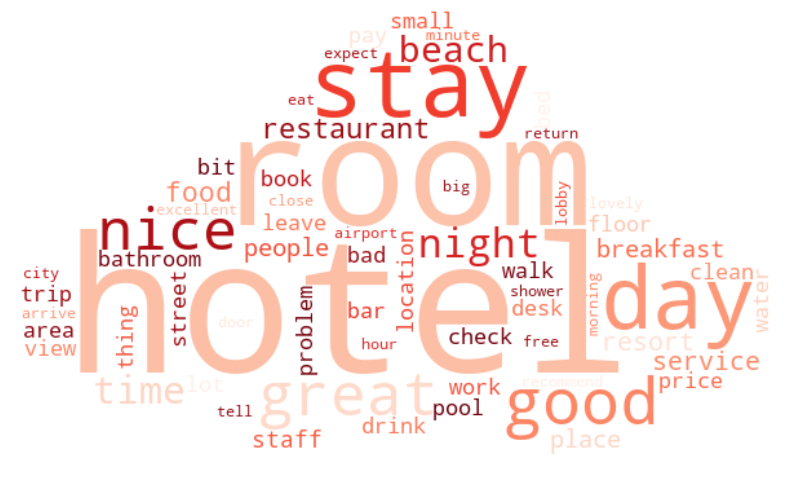

In [35]:
# Wordcloud for Negative Review

wordCloud_generator(train_neg, 'white', 'Reds')

**EXPLANATION :**

Based on the Wordcloud there is only slight difference between **Positive Reviews** and **Negative Reviews**. Both review are dominated with words like `hotel`, `room`, `stay`, `time`. But, in **Positive Reviews** there are much more positive and constructive words such as `excellent`, `fantastic`, `beautiful`, `wonderful`, and `love`. While **Negative Reviews** contains neutral to negative words, such as `bad`, `problem`, `small`, `service`, and `leave`. It means that even though both **Positive** and **Negative** mostly consist of the same words, but it has different meaning. 

In [36]:
# Create new dataframe to grouping the review star

top_rev = (df.groupby('Rating') 
            .agg(count=('Rating', 'count'))
            .reset_index()
            .sort_values('count',ascending=True)
            )
top_rev

,Rating,count
0,1,139
1,2,170
2,3,216
3,4,614
4,5,910


In [37]:
# change count datatype to float

top_rev['count'] = top_rev['count'].astype(float)

In [38]:
# Bars are sorted by the cumulative track length
top_rev = top_rev.sort_values('count', ascending=False)

# Values for the x axis
ANGLES = np.linspace(0.05, np.pi - 0.05, len(top_rev), endpoint=False)

# Cumulative length
LENGTHS = top_rev['count'].values

# Rating label
RATING = top_rev['Rating'].values

In [39]:
GREY12 = "#1f1f1f"

# Set default font color to GREY12
plt.rcParams["text.color"] = GREY12

# The minus glyph is not available in Bell MT
# This disables it, and uses a hyphen
plt.rc("axes", unicode_minus=True)

# Colors
COLORS = ["#e8c2ca","#d1b3c4","#b392ac","#735d78"]

# Colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("my color", COLORS, N=256)

# Normalizer
norm = mpl.colors.Normalize(vmin=LENGTHS.min(), vmax=LENGTHS.max())

# Normalized colors. Each number of tracks is mapped to a color in the 
# color scale 'cmap'
COLORS = cmap(norm(LENGTHS))

<function matplotlib.pyplot.show(close=None, block=None)>

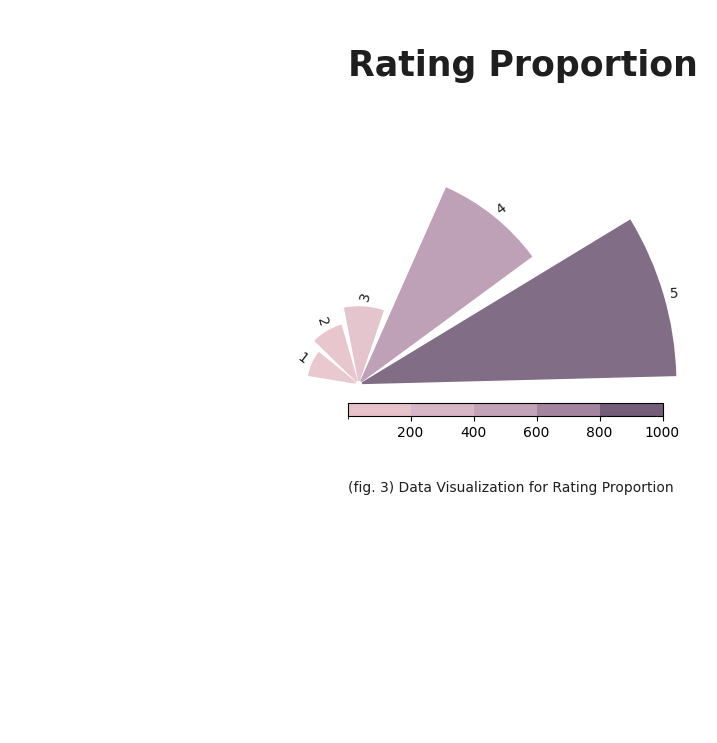

In [40]:
# Some layout stuff ----------------------------------------------
# Initialize layout in polar coordinates
fig, ax = plt.subplots(figsize=(9, 12.6), subplot_kw={"projection": "polar"})

# Set background color to white, both axis and figure.
fig.patch.set_facecolor("white")
ax.set_facecolor("white")

ax.set_theta_offset(4.15 * np.pi / 2)
ax.set_ylim(-10, 1000)

# Add geometries to the plot -------------------------------------
# See the zorder to manipulate which geometries are on top

# Add bars to represent the cumulative track lengths
bars = ax.bar(ANGLES, LENGTHS, color=COLORS, alpha=0.9, width=0.52, zorder=10)

# little space between the bar and the label
labelPadding = 20

# Constants = parameters controling the plot layout:
lowerLimit = -10

# Compute max and min in the dataset
max = top_rev['count'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# 0 in the dataset will be converted to the lowerLimit (-10)
slope = (max - lowerLimit) / max
heights = slope * top_rev['count'] + lowerLimit

# Compute the width of each bar. In total we have Pi = 180°
width = np.pi / len(top_rev.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(top_rev.index)+1))
angles = [element * width for element in indexes]
angles

# Add labels
for bar, angle, height, label in zip(bars,ANGLES, heights, top_rev['Rating']):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=labelPadding + bar.get_height(), 
        s=label, 
        ha=alignment, 
        va='center',
        size=10,
        rotation=rotation, 
        rotation_mode="anchor") 

# remove grid
plt.axis('off')

cbaxes = inset_axes(
    ax, 
    width="100%", 
    height="100%", 
    loc="center",
    bbox_to_anchor=(0.5, 0.43, 0.35, 0.01),
    bbox_transform=fig.transFigure # Note it uses the figure.
) 

# Create a new norm, which is discrete
bounds = [0, 200, 400, 600, 800, 1000]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Create the colorbar
cb = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap), 
    cax=cbaxes, # Use the inset_axes created above
    orientation = "horizontal",
    ticks=[200, 400, 600, 800, 1000]
)

# Add annotations
# Make some room for the title and subtitle above.
fig.subplots_adjust(top=0.8)

# Define title, subtitle, and caption
title = "\nRating Proportion"
caption = "(fig. 3) Data Visualization for Rating Proportion"

# And finally, add them to the plot.
fig.text(0.5, 0.7, title, fontsize=25, weight="bold", ha="left", va="baseline")
fig.text(0.5, 0.37, caption, fontsize=10, ha="left", va="baseline")

plt.show

Based on fig.3, rating proportion is dominated with 5-star review with almost surpassing 1000 reviews. 5-star review means that we providing good services or products to customers. Whilst for 4-star review means customer/reviewer enjoyed our service but may point out some areas for improvement, so it is not a good thing. For 3-star to 1-star review, we can considered it as a bad review.

Based on above explanation, we can categorize it :
- Good Review = 5-star
- Bad Review = 1-star to 4-star

So we can see the real proportion between good and bad review

In [41]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words,doc2vec_vector_0,...,word_year,word_yell,word_yellow,word_yes,word_yogurt,word_york,word_you,word_young,word_yummy,posneg
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48,0.007883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360,1.911419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27,-0.125178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320,0.200774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053745,0.0,0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98,0.389365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [42]:
# Create new dataframe to count the amount of Bad and Good Reviews
bad_good = (df.groupby('posneg') 
            .agg(count=('posneg', 'count'))
            .reset_index()
            .sort_values('count',ascending=True)
            )
bad_good

,posneg,count
1,1,910
0,0,1139


In [43]:
# Define data
names = bad_good['posneg']
size = bad_good['count']

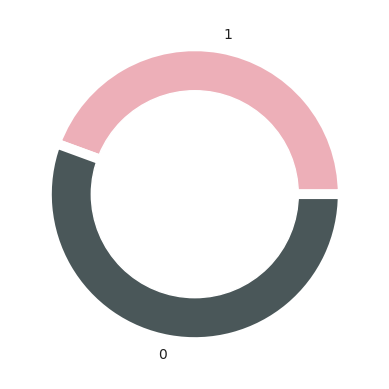

In [44]:
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' }, colors=['#edafb8','#4a5759'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Show the graph
plt.show()

Based on above chart, the proportion between **Good** and **Bad** reviews are almost the same, but still the total amount of **Bad** Review is higher than the **Good** one.

In [45]:
# Top 10 positive reviews

df[df['Words'] >= 5].sort_values('pos', ascending = False)[['Clean_Review', 'pos']].head(10)

,Clean_Review,pos
4073,hotel great hotel great money clean good restu...,0.799
2346,hotel hotel gorgeous beautiful clean spacious ...,0.763
12988,great stayed clarendon great stay employee con...,0.746
14475,great star hotel great room pretty small clean...,0.741
5566,excellent great staff glad choose hotel conven...,0.738
18668,fabulous hotel great hotel room amaze large gr...,0.733
8937,excellent great hotel recommend couple perfect...,0.721
11753,adore place clean spacious room extremely nice...,0.717
8122,love regina perfect great location lovely clea...,0.711
12044,lovely room great location stay lovely room sp...,0.709


In [46]:
# Top 10 negative reviews

df[df['Words'] >= 5].sort_values('neg', 
                                 ascending = False)[['Clean_Review', 
                                                     'neg']].head(10)

,Clean_Review,neg
9514,bad hotel awful place dirty room rude staff de...,0.646
19891,bad bad bad hotel verry bad pls stay close ram...,0.645
42,warwick bad good review warwick shock staff ru...,0.458
14744,stay bad resort stay day day long food poison ...,0.447
12123,awful hotel star hotel star room big dirty wal...,0.431
10952,hotel star hell star venue depress calamity ar...,0.431
2408,horrify stayed hotel october filthy terrible f...,0.424
6433,disappointing disappointed stay benjamin origi...,0.399
3979,place pretty bad room damp dirty water line ru...,0.396
3470,bad spa day spend huge family thing steal room...,0.391


**EXPLANATION:**

Obviously for **Positive Reviews**, dominated with words that show high customer satisfaction, such as `great`, `excellent`, `fabulous`, and `adore`. While **Negative Reviews** dominated with words that show low customer satisfaction, such as `bad`, `horrify`, `awful`, and `disappointing`.

## MODELING

In [47]:
df.head()

,Review,Rating,Clean_Review,neg,neu,pos,compound,Chars,Words,doc2vec_vector_0,...,word_year,word_yell,word_yellow,word_yes,word_yogurt,word_york,word_you,word_young,word_yummy,posneg
10726,not recommend hotel did reviewers actually sta...,1,recommend hotel reviewer stay hotel good thing...,0.267,0.637,0.096,-0.8384,312,48,0.007883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
14919,barcelona rocks \tstayed hotel jazz girlfriend...,4,barcelona rock stay hotel jazz girlfriend nigh...,0.138,0.685,0.177,0.9497,2479,360,1.911419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
19098,ok hotel good location stayed night way beijin...,3,hotel good location stay night beijing rawa is...,0.000,0.572,0.428,0.9217,164,27,-0.125178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2450,great service nice pool ok beach lovely ground...,4,great service nice pool beach lovely ground sm...,0.070,0.644,0.286,0.9978,2059,320,0.200774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053745,0.0,0
960,surprising treat spent weekend july 15/16 2006...,5,surprising treat spend weekend july cartwright...,0.059,0.639,0.302,0.9801,689,98,0.389365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2049 entries, 10726 to 5934
Columns: 1996 entries, Review to posneg
dtypes: float32(5), float64(1985), int64(4), object(2)
memory usage: 31.2+ MB


In [49]:
# drop the Review and Clean_Review Column, because we won't use it

df = df.drop(['Review', 'Clean_Review'], axis = 1)

In [50]:
target = df['posneg'].value_counts().reset_index()
target.rename(columns={'index':'posneg','posneg':'value'}, inplace=True)
target['percentage'] = round((target['value']/target['value'].sum())*100,2)
target

,value,count,percentage
0,0,1139,0.0
1,1,910,100.0


In [51]:
# Split dataset

X = df.drop(['posneg'],axis = 1)
Y = df['posneg']

### Random Forest

Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems.

It can perform both regression and classification tasks. A random forest produces good predictions that can be understood easily. It can handle large datasets efficiently. The random forest algorithm provides a higher level of accuracy in predicting outcomes over the decision tree algorithm.

[source](https://www.ibm.com/id-en/topics/random-forest#:~:text=Random%20forest%20is%20a%20commonly,both%20classification%20and%20regression%20problems) [source](https://www.section.io/engineering-education/introduction-to-random-forest-in-machine-learning/#:~:text=Advantages%20of%20random%20forest,over%20the%20decision%20tree%20algorithm.)

In [52]:
# split the dataset (train/test)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, 
                                                    Y, test_size=0.25, 
                                                    random_state=42)

In [53]:
# train the model

model = RandomForestClassifier(random_state=42)
model.fit(X_train_rf, y_train_rf)
preds = model.predict(X_test_rf)

In [54]:
classification_decision1 = (classification_report(y_test_rf, model.predict(X_test_rf)))

In [55]:
print(classification_decision1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       288
           1       1.00      0.98      0.99       225

    accuracy                           0.99       513
   macro avg       0.99      0.99      0.99       513
weighted avg       0.99      0.99      0.99       513



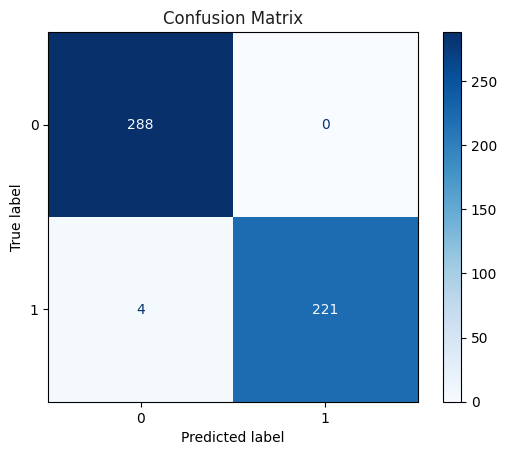

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already trained and evaluated your model, and have the predictions and ground truth labels
predictions = model.predict(X_test_rf)
cm = confusion_matrix(y_test_rf, predictions)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)

# Add labels, title, etc.
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#### Conclusion

Random Forest modeling able to achieve **97%** precision for negative reviews, it means that **97%** negative reviews are correctly classified as negative reviews, while **3%** of negative reviews are classified incorrectly. For positive reviews, it achieved **100%**, it means that all positive reviews are classified as positive reviews and none of the positive reviews are classified incorrectly.

Recall value or True Positive Rate (TPR), predicted how much a machine learning model correctly identifies all relevant cases withing the dataset. In this case, our model able to predicted that **100%** from the dataset are **True Positive** for negative reviews, and **96%** from the dataset are **True Positive** for positive reviews.

F1-score value measures how many times the model made a correct prediction accurately. Our logistic regression model able to predict **99%** correctly for negative reviews and **98%** correctly for positive reviews.

### Logistic Regression

Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set. A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables. Here we are using logistic regression for the effective accuracy and the prediction of the data set.

[source](https://www.techtarget.com/searchbusinessanalytics/definition/logistic-regression#:~:text=Logistic%20regression%20is%20a%20statistical,or%20more%20existing%20independent%20variables.) [source](https://www.researchgate.net/publication/353514662_Sentimental_Analysis_using_Logistic_Regression#:~:text=Sentiment%20analysis%20has%20emerged%20as,prediction%20of%20the%20data%20set.)

In [64]:
X_train_lr, X_test_lr,y_train_lr,y_test_lr = train_test_split(X,
                                                Y,
                                                test_size = 0.3,
                                                random_state = 42)

In [65]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_lr, y_train_lr)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [66]:
classification_decision2 = (classification_report(y_test_lr, logreg.predict(X_test_lr)))

In [67]:
print(classification_decision2)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       350
           1       1.00      1.00      1.00       265

    accuracy                           1.00       615
   macro avg       1.00      1.00      1.00       615
weighted avg       1.00      1.00      1.00       615



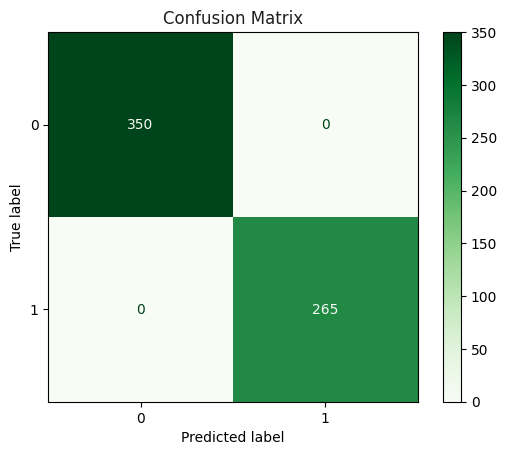

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming you have already trained and evaluated your model, and have the predictions and ground truth labels
predictions = logreg.predict(X_test_lr)
cm = confusion_matrix(y_test_lr, predictions)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Greens)

# Add labels, title, etc.
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


#### Conclusion

Logistic Regression conclude a higher overall value than **Random Forest**, from precision, recall, and F1 score for positive and negative reviews. 

Precision value equal to **100%** for **0**, means that all negative reviews are classified as negative reviews and none of the negative reviews are classified incorrectly. While precision value for positive reviews equal to **0.99**, it means that **99%** of positive reviews are classified as positive reviews and **1%** of the positive reviews are classified incorrectly.

Recall value or True Positive Rate (TPR), predicted how much a machine learning model correctly identifies all relevant cases withing the dataset. In this case, our model able to predicted that **99%** from the dataset are **True Positive** for negative reviews, and **100%** from the dataset are **True Positive** for positive reviews.

F1-score value measures how many times the model made a correct prediction accurately. Our logistic regression model able to predict **100%** correctly for negative reviews and **99%** correctly for positive reviews.